# 集成学习(Ensemble Learning)

- 实现多种机器学习算法
- 运行多种算法进行投票
- 随机森林是一种集成学习

## 自我实现

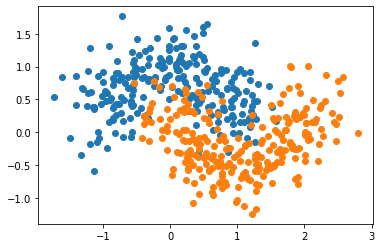

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

X, y = datasets.make_moons(n_samples=500, noise=0.3, random_state=42)
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 算法1
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression()
log_clf.fit(X_train, y_train)
log_clf.score(X_test, y_test)

# 算法2
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.score(X_test, y_test)

# 算法3
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=666)
dt_clf.fit(X_train, y_train)
dt_clf.score(X_test, y_test)

# 集合算法1,算法2, 算法3
y_predict1 = log_clf.predict(X_test)
y_predict2 = svm_clf.predict(X_test)
y_predict3 = dt_clf.predict(X_test)
y_predict = np.array((y_predict1 + y_predict2 + y_predict3) >= 2, dtype='int')

accuracy_score(y_test, y_predict)

0.904

## sklearn实现


### Hard voting

- 少数服从多数,有时候有问题  
- 例如少数人的暴政
- 没有考虑"专家"的意见(可能有些算法100%确定,有些只有51%确定)
- ![](https://raw.githubusercontent.com/LinCheungS/PicGo_Image_Storage/master/2020/20200417201245.png)

In [3]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[
    ('log_clf', LogisticRegression()), 
    ('svm_clf', SVC()),
    ('dt_clf', DecisionTreeClassifier(random_state=666))],
                             voting='hard')

voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.904

### Soft voting

- 有些模型的权值应该更大
- 就像歌唱比赛的专家票  
- 把每个模型的估计概率算进去,必须获得概率
- ![](https://raw.githubusercontent.com/LinCheungS/PicGo_Image_Storage/master/2020/20200417201410.png)

- 逻辑回归支持概率
- KNN支持估计概率
- 决策树支持估计概率
- SVM支持估计概率(复杂)

In [4]:
# svm probability=True
voting_clf2 = VotingClassifier(estimators=[
    ('log_clf', LogisticRegression()), 
    ('svm_clf', SVC(probability=True)),
    ('dt_clf', DecisionTreeClassifier())],
                             voting='soft')

voting_clf2.fit(X_train, y_train)
voting_clf2.score(X_test, y_test)

0.904

## Bagging和Boosting

- 样例权重：
    - Bagging：使用均匀取样，每个样例的权重相等
    - Boosting：根据错误率不断调整样例的权值，错误率越大则权重越大。

- 预测函数：
    - Bagging：所有预测函数的权重相等。
    - Boosting：每个弱分类器都有相应的权重，对于分类误差小的分类器会有更大的权重。

- 并行计算：
    - Bagging：各个预测函数可以并行生成
    - Boosting：各个预测函数只能顺序生成，因为后一个模型参数需要前一轮模型的结果。

![](https://raw.githubusercontent.com/LinCheungS/PicGo_Image_Storage/master/2020-1/20200423043002.png)
![](https://raw.githubusercontent.com/LinCheungS/PicGo_Image_Storage/master/2020-1/20200423043011.png)

## Bagging

#### 原理

- 也称作“套袋法”
- 创建更多的子模型,集成更多子模型意见
- 子模型之间不能一致, 子模型之间要有**差异性**
- 每个子模型模型只看样本数据的一部分
  - 一共有500个样本数据;每个子模型只看100个样本数据
  - 每个子模型不需要太高准确率
     - 如果每个子模型只有51%准确率
     - 如果我们只有1个子模型, 整体准确率51%
     - 如果有3个子模型, 整体${\rm{0}}{\rm{.5}}{{\rm{1}}^{\rm{3}}}{\rm{ + C}}_{\rm{3}}^{\rm{2}} \cdot {\rm{0}}{\rm{.5}}{{\rm{1}}^{\rm{2}}} \cdot {\rm{0}}{\rm{.49 = 51}}{\rm{.5\% }}$ (3个说对+两个说对)
     - 如果有500个模型,整体$\sum\limits_{{\rm{i = 251}}}^{{\rm{500}}} {{\rm{C}}_{{\rm{500}}}^{\rm{i}}}  \cdot {\rm{0}}{\rm{.5}}{{\rm{1}}^{\rm{i}}} \cdot {\rm{0}}{\rm{.4}}{{\rm{9}}^{{\rm{500 - i}}}}{\rm{ = 65}}{\rm{.6}}$ (251说对+252说对+...+500说对)
     - 如果每个模型准确率是60%, 500个模型的准确率99.99%  
  


#### Bagging和Pasting

- 放回取样 (bagging)
  - Bootsrap 统计学叫法
  - 更常用
  - 不强烈依赖于随机
- 不放回取样 (pasting)
  - 依赖随机, 怎么分子模型很重要

#### sklearn实现Bagging(bootstrap)

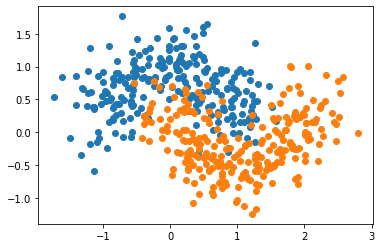

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

X, y = datasets.make_moons(n_samples=500, noise=0.3, random_state=42)
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [7]:
# 500个子模型
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                           n_estimators=500, max_samples=100,
                           bootstrap=True)
bagging_clf.fit(X_train, y_train)
bagging_clf.score(X_test, y_test)

0.92

In [8]:
# 5000个子模型
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                           n_estimators=5000, max_samples=100,
                           bootstrap=True)
bagging_clf.fit(X_train, y_train)
bagging_clf.score(X_test, y_test)

0.912

#### 超参数

##### OOB(Out of Bag)

- 放回取样导致一部分样本可能没有取到
- 平均大约有37%的样本没有渠道
- 不需要使用train_test_split, 而使用这部分没有取到的样本做测试/验证
- oob_score_来衡量模型

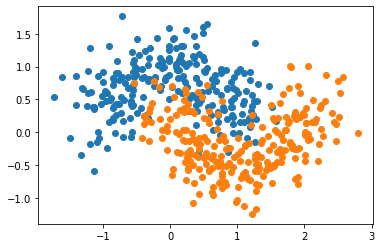

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
# 不进行train_test_split
X, y = datasets.make_moons(n_samples=500, noise=0.3, random_state=42)
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=500, max_samples=100,
                               bootstrap=True, oob_score=True)
bagging_clf.fit(X, y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


In [18]:
bagging_clf.oob_score_

0.918

##### n_jobs(多核)

In [19]:
%%time
bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=500, max_samples=100,
                               bootstrap=True, oob_score=True)
bagging_clf.fit(X, y)

CPU times: user 729 ms, sys: 10.4 ms, total: 739 ms
Wall time: 741 ms


BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


In [20]:
%%time
bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=500, max_samples=100,
                               bootstrap=True, oob_score=True,
                               n_jobs=-1)
bagging_clf.fit(X, y)

CPU times: user 231 ms, sys: 7.46 ms, total: 238 ms
Wall time: 620 ms


BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


##### bootstrap_features

- 对特征进行随机取样
  - x的维度高(例如图像识别)
  - random subspaces
- 即针对样本, 又针对特征进行随机采样
  - random patches

In [21]:
random_subspaces_clf = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=500, max_samples=500,
                               bootstrap=True, oob_score=True,
                               max_features=1, bootstrap_features=True)
random_subspaces_clf.fit(X, y)
random_subspaces_clf.oob_score_

0.828

In [22]:
random_patches_clf = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=500, max_samples=100,
                               bootstrap=True, oob_score=True,
                               max_features=1, bootstrap_features=True)
random_patches_clf.fit(X, y)
random_patches_clf.oob_score_

0.858

## Boosting的方式

- 集成多个模型
- 每个模型都在尝试增强(boosting)整体的效果
- 没有out of bag  
  
![](https://raw.githubusercontent.com/LinCheungS/PicGo_Image_Storage/master/2020-1/20200423043002.png)
![](https://raw.githubusercontent.com/LinCheungS/PicGo_Image_Storage/master/2020-1/20200423043011.png)

#### Ada Boosting

- 将多个弱分类器（弱分类器一般选用单层决策树）进行合理的结合，使其成为一个强分类器
- 整合原理进行权重的调整
- 上一次拟合不好的数据提高权重
- 每个子模型试图弥补上一个子模型错误
![](https://raw.githubusercontent.com/LinCheungS/PicGo_Image_Storage/master/2020/20200418004941.PNG)  
  
- AdaBoost算法优点：
    - 很好的利用了弱分类器进行级联；
    - 可以将不同的分类算法作为弱分类器；
    - AdaBoost具有很高的精度；
    - 相对于bagging算法和Random Forest算法，AdaBoost充分考虑的每个分类器的权重；
- Adaboost算法缺点：
    - AdaBoost迭代次数也就是弱分类器数目不太好设定，可以使用交叉验证来进行确定；
    - 数据不平衡导致分类精度下降；
    - 训练比较耗时，每次重新选择当前分类器最好切分点；

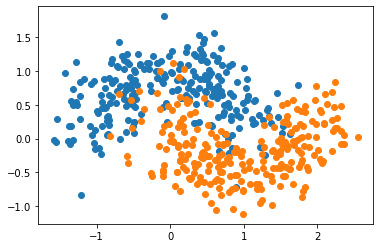

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
X, y = datasets.make_moons(n_samples=500, noise=0.3, random_state=666)
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2), n_estimators=500)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [4]:
ada_clf.score(X_test, y_test)

0.864

#### Gradient Boosting

- 训练一个模型m1, 产生错误e1
- 针对e1训练第二个模型m2,产生错误e2
- 针对e2训练第三个模型m3, 产生错误e3
- 最终预测结果 m1+m2+m3+.....
![](https://raw.githubusercontent.com/LinCheungS/PicGo_Image_Storage/master/2020/20200418005504.PNG)

In [5]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(max_depth=2, n_estimators=30)
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=30,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [6]:
gb_clf.score(X_test, y_test)

0.904

#### boosting解决回归问题

In [0]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

#### 集成学习解决回归问题

In [0]:
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor